# Toronto Segmentation and Clustering

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Fetching package metadata .............
Solving package specifications: .

# All requested packages already installed.
# packages in environment at /opt/conda/envs/DSX-Python35:
#
geopy                     1.18.1                     py_0    conda-forge
Fetching package metadata .............
Solving package specifications: .

# All requested packages already installed.
# packages in environment at /opt/conda/envs/DSX-Python35:
#
folium                    0.5.0                      py_0    conda-forge
Libraries imported.


## 1. Get Toronto Postal Code and process the dataset

In [2]:
wiki_link='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
wiki_tables = pd.read_html(wiki_link)
Toronto_zip_table = wiki_tables[0]

Toronto_zip_table.columns = Toronto_zip_table.iloc[0]
Toronto_zip_table.drop(0, inplace = True)
Toronto_zip_table.reset_index(inplace = True, drop = True)
Toronto_zip_table.columns = ['Postalcode', 'Borough', 'Neighbourhood']

#### Loop through the dataframe to drop rows where Borough =  'Not Assigned' and change Neighbourhood to Borough if Neighbourhood = 'Not Assigned'

In [3]:

for inx in Toronto_zip_table.index:
    if Toronto_zip_table['Borough'][inx] == 'Not assigned':
        Toronto_zip_table.drop(axis = 0, index = inx, inplace = True)
    elif Toronto_zip_table['Neighbourhood'][inx] == 'Not assigned':
        Toronto_zip_table['Neighbourhood'][inx] = Toronto_zip_table['Borough'][inx]

#Toronto_zip_table.reset_index(inplace = True, drop = True)
Toronto_zip_table.head(10)

,Postalcode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights
7,M6A,North York,Lawrence Manor
8,M7A,Queen's Park,Queen's Park
10,M9A,Etobicoke,Islington Avenue
11,M1B,Scarborough,Rouge
12,M1B,Scarborough,Malvern


#### Combine rows with Postal Code across different Neighborhoods into one row with comma-separated Neighbourhoods

In [4]:

Toronto_zip_table.sort_values(by = ['Postalcode', 'Borough', 'Neighbourhood'], inplace = True)

Toronto_zip_table = Toronto_zip_table.groupby(['Postalcode', 'Borough'])['Neighbourhood'].apply(lambda x: ', '.join(x.astype(str))).reset_index()
Toronto_zip_table.head(10)


,Postalcode,Borough,Neighbourhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Highland Creek, Port Union, Rouge Hill"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park"
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge"
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West"
9,M1N,Scarborough,"Birch Cliff, Cliffside West"


In [5]:
print('There are {} rows in the Toronto Postal Code DataFrame'.format(Toronto_zip_table.shape[0]))

There are 103 rows in the Toronto Postal Code DataFrame


#### Read Geospatial data from csv and get lat-long for Toronto postcodes

In [6]:
import sys
import types
import pandas as pd
from ibm_botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share your notebook.
client_c9f19e9623c7413db1ee38fbae5e4995 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='Y3VnJULYOo-Uvrvi5HimJm2cIHDvZumlvofJLw5MTGQY',
    ibm_auth_endpoint="https://iam.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_c9f19e9623c7413db1ee38fbae5e4995.get_object(Bucket='torontoneighborhoodanalysis-donotdelete-pr-hby8mbtcoxk9zh',Key='Geospatial_Coordinates.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

geo_data = pd.read_csv(body)
geo_data.columns = ['Postalcode', 'Latitude', 'Longitude']
geo_data.head(10)

,Postalcode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476
5,M1J,43.744734,-79.239476
6,M1K,43.727929,-79.262029
7,M1L,43.711112,-79.284577
8,M1M,43.716316,-79.239476
9,M1N,43.692657,-79.264848


In [7]:
Toronto_lat_long_table = pd.merge(Toronto_zip_table, geo_data, on='Postalcode', how='inner')
Toronto_lat_long_table.head(10)

,Postalcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Port Union, Rouge Hill",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.727929,-79.262029
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.711112,-79.284577
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848


#### Filter to Boroughs that have 'Toronto' in the name

In [8]:
Filter = (Toronto_lat_long_table['Borough'] == 'East Toronto') | (Toronto_lat_long_table['Borough'] == 'Central Toronto') | (Toronto_lat_long_table['Borough'] == 'Downtown Toronto') | (Toronto_lat_long_table['Borough'] == 'West Toronto')
Toronto_Boroughs = Toronto_lat_long_table[Filter].reset_index(drop = True)
Toronto_Boroughs.head(10)

,Postalcode,Borough,Neighbourhood,Latitude,Longitude
0,M4E,East Toronto,The Beaches,43.676357,-79.293031
1,M4K,East Toronto,"Riverdale, The Danforth West",43.679557,-79.352188
2,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572
3,M4M,East Toronto,Studio District,43.659526,-79.340923
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790
5,M4P,Central Toronto,Davisville North,43.712751,-79.390197
6,M4R,Central Toronto,North Toronto West,43.715383,-79.405678
7,M4S,Central Toronto,Davisville,43.704324,-79.388790
8,M4T,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.383160
9,M4V,Central Toronto,"Deer Park, Forest Hill SE, Rathnelly, South Hi...",43.686412,-79.400049


#### Plot map of all neighbourhoods from the Toronto Boroughs

In [9]:
address = 'Toronto, ON'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:3: DeprecationWarning: Using Nominatim with the default "geopy/1.18.1" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  app.launch_new_instance()


The geograpical coordinate of Toronto are 43.653963, -79.387207.


In [54]:
# create map of Toronto using latitude and longitude values
map_Toronto = folium.Map(location=[latitude, longitude], zoom_start=12)


# add markers to map
for lat, lng, label in zip(Toronto_Boroughs['Latitude'], Toronto_Boroughs['Longitude'], Toronto_Boroughs['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Toronto)  
    
map_Toronto

#### Set up credentials for FourSquare API

In [55]:
CLIENT_ID = 'XXXXXXXX' # your Foursquare ID
CLIENT_SECRET = 'XXXXXXXXXX' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

#### Function to get category of rows from FourSquare Data

In [12]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

## 2. Explore Toronto Neighbourhoods

#### Function to get venues from all neighbourhoods

In [13]:
def getNearbyVenues(borough, names, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for borough, name, lat, lng in zip(borough, names, latitudes, longitudes):
        print(borough + ', ' + name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            borough,
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough',
                  'Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [14]:
Toronto_venues = getNearbyVenues(borough = Toronto_Boroughs['Borough'],
                                   names = Toronto_Boroughs['Neighbourhood'],
                                   latitudes=Toronto_Boroughs['Latitude'],
                                   longitudes=Toronto_Boroughs['Longitude'])

East Toronto, The Beaches
East Toronto, Riverdale, The Danforth West
East Toronto, India Bazaar, The Beaches West
East Toronto, Studio District
Central Toronto, Lawrence Park
Central Toronto, Davisville North
Central Toronto, North Toronto West
Central Toronto, Davisville
Central Toronto, Moore Park, Summerhill East
Central Toronto, Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West
Downtown Toronto, Rosedale
Downtown Toronto, Cabbagetown, St. James Town
Downtown Toronto, Church and Wellesley
Downtown Toronto, Harbourfront, Regent Park
Downtown Toronto, Garden District, Ryerson
Downtown Toronto, St. James Town
Downtown Toronto, Berczy Park
Downtown Toronto, Central Bay Street
Downtown Toronto, Adelaide, King, Richmond
Downtown Toronto, Harbourfront East, Toronto Islands, Union Station
Downtown Toronto, Design Exchange, Toronto Dominion Centre
Downtown Toronto, Commerce Court, Victoria Hotel
Central Toronto, Roselawn
Central Toronto, Forest Hill North, Forest Hill West
Ce

In [15]:
Toronto_venues.head(2)

,Borough,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,East Toronto,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
1,East Toronto,The Beaches,43.676357,-79.293031,Starbucks,43.678798,-79.298045,Coffee Shop


In [16]:
Toronto_venues.groupby(['Borough', 'Neighbourhood']).count()

Neighbourhood Latitude  \
Borough          Neighbourhood                                                                
Central Toronto  Davisville                                                              34   
                 Davisville North                                                         7   
                 Deer Park, Forest Hill SE, Rathnelly, South Hil...                      14   
                 Forest Hill North, Forest Hill West                                      5   
                 Lawrence Park                                                            4   
                 Moore Park, Summerhill East                                              2   
                 North Midtown, The Annex, Yorkville                                     24   
                 North Toronto West                                                      19   
                 Roselawn                                                                 2   
Downtown Toronto Adelaide, King, Richmond                                               100   
                 Bathurst Quay, CN Tower, Harbourfront West, Isl...                      14   
                 Berczy Park                                                             54   
                 Cabbagetown, St. James Town                                             47   
                 Central Bay Street                                                      85   
                 Chinatown, Grange Park, Kensington Market                              100   
                 Christie                                                                16   
                 Church and Wellesley                                                    88   
                 Commerce Court, Victoria Hotel                                         100   
                 Design Exchange, Toronto Dominion Centre                               100   
                 First Canadian Place, Underground city                                 100   
                 Garden District, Ryerson                                               100   
                 Harbord, University of Toronto                                          36   
                 Harbourfront East, Toronto Islands, Union Station                      100   
                 Harbourfront, Regent Park                                               48   
                 Rosedale                                                                 4   
                 St. James Town                                                         100   
                 Stn A PO Boxes 25 The Esplanade                                         94   
East Toronto     Business Reply Mail Processing Centre 969 Eastern                       17   
                 India Bazaar, The Beaches West                                          19   
                 Riverdale, The Danforth West                                            42   
                 Studio District                                                         40   
                 The Beaches                                                              4   
West Toronto     Brockton, Exhibition Place, Parkdale Village                            20   
                 Dovercourt Village, Dufferin                                            21   
                 High Park, The Junction South                                           23   
                 Little Portugal, Trinity                                                66   
                 Parkdale, Roncesvalles                                                  16   
                 Runnymede, Swansea                                                      35   

                                                                     Neighbourhood Longitude  \
Borough          Neighbourhood                                                                 
Central Toronto  Davisville                                                 

In [17]:
print('There are {} uniques categories.'.format(len(Toronto_venues['Venue Category'].unique())))

There are 238 uniques categories.


## 3. Analyze Each Neighborhood

In [18]:
# one hot encoding
Toronto_onehot = pd.get_dummies(Toronto_venues[['Venue Category']], prefix="", prefix_sep="")
# add neighborhood column back to dataframe
Toronto_onehot['Borough'] = Toronto_venues['Borough'] 
Toronto_onehot['Neighbourhood'] = Toronto_venues['Neighbourhood'] 

fixed_columns = list(Toronto_onehot.columns[-2:]) + list(Toronto_onehot.columns[:-2])
Toronto_onehot = Toronto_onehot[fixed_columns]

Toronto_onehot.head()

,Borough,Neighbourhood,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Astrologer,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Piano Bar,Pizza Place,Plane,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,East Toronto,The Beaches,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,East Toronto,The Beaches,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [19]:
Toronto_onehot.shape

(1700, 240)

In [20]:
Toronto_grouped = Toronto_onehot.groupby('Neighbourhood').mean().reset_index()
Toronto_grouped.head()

,Neighbourhood,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Astrologer,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Piano Bar,Pizza Place,Plane,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,"Adelaide, King, Richmond",0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.04,0.0,0.0,0.0,0.010000,0.01,0.0,0.03,0.0,0.0,0.000000,0.0,0.0,0.000000,0.030000,0.0,0.03,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.02,0.000000,0.01,0.02,0.000000,0.0,0.01,0.02,0.010000,0.0,0.0,0.0,0.000000,0.050000,0.0,0.00,0.000000,0.0,0.0,0.0,0.00,0.030000,0.010000,0.060000,0.0,0.0,0.0,0.000000,0.000000,0.020000,0.00,0.020000,0.0,0.000000,0.0,0.0,0.0,0.01,0.01,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0

#### Function to get top categories in descending order

In [21]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#### Display top 10 venues across all neighbourhoods

In [22]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = Toronto_grouped['Neighbourhood']

for ind in np.arange(Toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Café,Thai Restaurant,Steakhouse,American Restaurant,Restaurant,Asian Restaurant,Bakery,Bar,Gym
1,"Bathurst Quay, CN Tower, Harbourfront West, Is...",Airport Service,Airport Terminal,Airport Lounge,Harbor / Marina,Boat or Ferry,Sculpture Garden,Plane,Boutique,Airport Gate,Airport Food Court
2,Berczy Park,Coffee Shop,Restaurant,Cocktail Bar,Pub,Café,Cheese Shop,Seafood Restaurant,Italian Restaurant,Steakhouse,Bakery
3,"Brockton, Exhibition Place, Parkdale Village",Coffee Shop,Café,Breakfast Spot,Gym,Furniture / Home Store,Performing Arts Venue,Pet Store,Gym / Fitness Center,Nightclub,Climbing Gym
4,Business Reply Mail Processing Centre 969 Eastern,Light Rail Station,Park,Garden,Smoke Shop,Farmers Market,Fast Food Restaurant,Spa,Brewery,Burrito Place,Restaurant
5,"Cabbagetown, St. James Town",Coffee Shop,Restaurant,Pharmacy,Italian Restaurant,Bakery,Pizza Place,Pub,Park,Café,Market
6,Central Bay Street,Coffee Shop,Café,Italian Restaurant,Burger Joint,Ice Cream Shop,Bar,Middle Eastern Restaurant,Sandwich Place,Falafel Restaurant,Spa
7,"Chinatown, Grange Park, Kensington Market",Café,Bar,Vegetarian / Vegan Restaurant,Dumpling Restaurant,Vietnamese Restaurant,Bakery,Coffee Shop,Mexican Restaurant,Chinese Restaurant,Burger Joint
8,Christie,Café,Grocery Store,Park,Restaurant,Athletics & Sports,Baby Store,Diner,Nightclub,Italian Restaurant,Coffee Shop
9,Church and Wellesley,Japanese Restaurant,Sushi Restaurant,Coffee Shop,Gay Bar,Restaurant,Burger Joint,Gastropub,Café,Fast Food Restaurant,Mediterranean Restaurant


## 4. Cluster Neighbourhoods

#### We begin by identifying the optimum K by the 'Elbow Method'

In [33]:
Toronto_grouped_clustering = Toronto_grouped.drop('Neighbourhood', 1)

Sum_of_squared_distances = []
K = range(1, 30)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(Toronto_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)

In [34]:
optimal_k= pd.DataFrame(data= Sum_of_squared_distances, columns = ['Sum of squared distances'], index = K)
optimal_k.rename_axis('K', axis = 'columns', inplace = True)

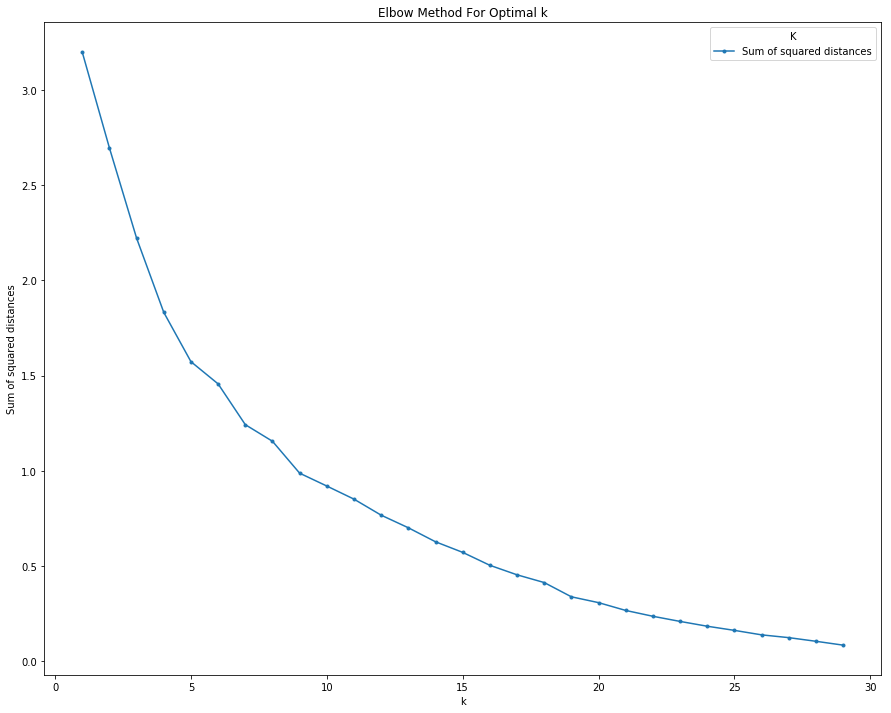

In [52]:
optimal_k.plot(kind = 'line', figsize = (15, 12), marker = '.')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [38]:
# set number of clusters
kclusters = 9

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 6, 0, 0, 0, 0, 0], dtype=int32)

In [39]:
Toronto_merged = Toronto_Boroughs

# add clustering labels
Toronto_merged['Cluster Labels'] = kmeans.labels_

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Toronto_merged = Toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

Toronto_merged.head() # check the last columns!

,Postalcode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,Coffee Shop,Neighborhood,Pub,Astrologer,Yoga Studio,Donut Shop,Discount Store,Dog Run,Doner Restaurant,Eastern European Restaurant
1,M4K,East Toronto,"Riverdale, The Danforth West",43.679557,-79.352188,0,Greek Restaurant,Coffee Shop,Ice Cream Shop,Bookstore,Italian Restaurant,Yoga Studio,Furniture / Home Store,Pub,Pizza Place,Liquor Store
2,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572,0,Park,Pet Store,Ice Cream Shop,Brewery,Liquor Store,Sandwich Place,Fast Food Restaurant,Burger Joint,Fish & Chips Shop,Burrito Place
3,M4M,East Toronto,Studio District,43.659526,-79.340923,0,Café,Coffee Shop,Yoga Studio,Bakery,Italian Restaurant,American Restaurant,Middle Eastern Restaurant,Fish Market,Juice Bar,Latin American Restaurant
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,6,Dim Sum Restaurant,Park,Swim School,Bus Line,Diner,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store


#### Creating map of resulting clusters

In [40]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12, tiles = 'Stamentoner')

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Toronto_merged['Latitude'], Toronto_merged['Longitude'], Toronto_merged['Neighbourhood'], Toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 5. Examine Clusters

### Cluster 1

#### The first cluster is characterized by Shops and Restaurants

In [41]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 0, Toronto_merged.columns[[1] + [2] + list(range(5, Toronto_merged.shape[1]))]].head()

,Borough,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,East Toronto,The Beaches,0,Coffee Shop,Neighborhood,Pub,Astrologer,Yoga Studio,Donut Shop,Discount Store,Dog Run,Doner Restaurant,Eastern European Restaurant
1,East Toronto,"Riverdale, The Danforth West",0,Greek Restaurant,Coffee Shop,Ice Cream Shop,Bookstore,Italian Restaurant,Yoga Studio,Furniture / Home Store,Pub,Pizza Place,Liquor Store
2,East Toronto,"India Bazaar, The Beaches West",0,Park,Pet Store,Ice Cream Shop,Brewery,Liquor Store,Sandwich Place,Fast Food Restaurant,Burger Joint,Fish & Chips Shop,Burrito Place
3,East Toronto,Studio District,0,Café,Coffee Shop,Yoga Studio,Bakery,Italian Restaurant,American Restaurant,Middle Eastern Restaurant,Fish Market,Juice Bar,Latin American Restaurant
5,Central Toronto,Davisville North,0,Food & Drink Shop,Gym,Park,Sandwich Place,Burger Joint,Breakfast Spot,Hotel,Yoga Studio,Doner Restaurant,Donut Shop


### Cluster 2

#### The second cluster contains only one neighbourhood and is characterized by Pharmacy and Stores

In [42]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 1, Toronto_merged.columns[[1] + [2] + list(range(5, Toronto_merged.shape[1]))]].head()

,Borough,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
31,West Toronto,"Dovercourt Village, Dufferin",1,Pharmacy,Supermarket,Discount Store,Bakery,Fast Food Restaurant,Liquor Store,Middle Eastern Restaurant,Music Venue,Park,Pool


### Cluster 3

#### The Third cluster is characterized by Coffee Shop

In [43]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 2, Toronto_merged.columns[[1] + [2] + list(range(5, Toronto_merged.shape[1]))]].head()

,Borough,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
24,Central Toronto,"North Midtown, The Annex, Yorkville",2,Coffee Shop,Sandwich Place,Café,Pizza Place,Pub,BBQ Joint,Indian Restaurant,Flower Shop,Jewish Restaurant,Liquor Store


### Cluster 4

#### The Fourth cluster is characterized by Bars

In [44]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 3, Toronto_merged.columns[[1] + [2] + list(range(5, Toronto_merged.shape[1]))]].head()

,Borough,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
32,West Toronto,"Little Portugal, Trinity",3,Bar,Men's Store,Asian Restaurant,Coffee Shop,Café,Restaurant,Pizza Place,Bakery,Vietnamese Restaurant,Cocktail Bar


### Cluster 5

#### The Fifth cluster contains only one neighbourhood and is characterized by Asian Restaurant

In [45]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 4, Toronto_merged.columns[[1] + [2] + list(range(5, Toronto_merged.shape[1]))]].head()

,Borough,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
26,Downtown Toronto,"Chinatown, Grange Park, Kensington Market",4,Café,Bar,Vegetarian / Vegan Restaurant,Dumpling Restaurant,Vietnamese Restaurant,Bakery,Coffee Shop,Mexican Restaurant,Chinese Restaurant,Burger Joint


### Cluster 6

#### The Sixth cluster is a business district and is characterized by Rail Station

In [46]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 5, Toronto_merged.columns[[1] + [2] + list(range(5, Toronto_merged.shape[1]))]].head()

,Borough,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
37,East Toronto,Business Reply Mail Processing Centre 969 Eastern,5,Light Rail Station,Park,Garden,Smoke Shop,Farmers Market,Fast Food Restaurant,Spa,Brewery,Burrito Place,Restaurant


### Cluster 7

#### The Seventh cluster contains is characterized places for recreational activities like Park and Swimming

In [47]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 6, Toronto_merged.columns[[1] + [2] + list(range(5, Toronto_merged.shape[1]))]].head()

,Borough,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Central Toronto,Lawrence Park,6,Dim Sum Restaurant,Park,Swim School,Bus Line,Diner,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store
23,Central Toronto,"Forest Hill North, Forest Hill West",6,Trail,Jewelry Store,Sushi Restaurant,Bus Line,Park,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Diner


### Cluster 8

#### The Eigth cluster contains only one neighbourhood and is characterized by Restaurants

In [48]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 7, Toronto_merged.columns[[1] + [2] + list(range(5, Toronto_merged.shape[1]))]].head()

,Borough,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
17,Downtown Toronto,Central Bay Street,7,Coffee Shop,Café,Italian Restaurant,Burger Joint,Ice Cream Shop,Bar,Middle Eastern Restaurant,Sandwich Place,Falafel Restaurant,Spa


### Cluster 9

#### The Ninth cluster contains only one neighbourhood and is characterized by Japanese Restaurants

In [49]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 8, Toronto_merged.columns[[1] + [2] + list(range(5, Toronto_merged.shape[1]))]].head()

,Borough,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,Downtown Toronto,Church and Wellesley,8,Japanese Restaurant,Sushi Restaurant,Coffee Shop,Gay Bar,Restaurant,Burger Joint,Gastropub,Café,Fast Food Restaurant,Mediterranean Restaurant
